In [1]:
from importlib.metadata import version

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.5.0
tiktoken version: 0.8.0


## Data Exploration

In [3]:
import re

# Dataset: https://en.wikisource.org/wiki/The_Verdict
with open("dataset/the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
    
# print("Total number of character:", len(raw_text))
# print(raw_text[:99])

preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item for item in preprocessed if item]
# print(preprocessed[:38])
# print("Number of tokens:", len(preprocessed))

all_words = sorted(set(preprocessed))
vocab_size = len(all_words)

# print(vocab_size)

vocab = {token:integer for integer,token in enumerate(all_words)}
vocab
# for i, item in enumerate(vocab.items()):
#     print(item)
#     if i >= 50:
#         break

{'\n': 0,
 ' ': 1,
 '!': 2,
 '"': 3,
 "'": 4,
 '(': 5,
 ')': 6,
 ',': 7,
 '--': 8,
 '.': 9,
 ':': 10,
 ';': 11,
 '?': 12,
 'A': 13,
 'Ah': 14,
 'Among': 15,
 'And': 16,
 'Are': 17,
 'Arrt': 18,
 'As': 19,
 'At': 20,
 'Be': 21,
 'Begin': 22,
 'Burlington': 23,
 'But': 24,
 'By': 25,
 'Carlo': 26,
 'Chicago': 27,
 'Claude': 28,
 'Come': 29,
 'Croft': 30,
 'Destroyed': 31,
 'Devonshire': 32,
 'Don': 33,
 'Dubarry': 34,
 'Emperors': 35,
 'Florence': 36,
 'For': 37,
 'Gallery': 38,
 'Gideon': 39,
 'Gisburn': 40,
 'Gisburns': 41,
 'Grafton': 42,
 'Greek': 43,
 'Grindle': 44,
 'Grindles': 45,
 'HAD': 46,
 'Had': 47,
 'Hang': 48,
 'Has': 49,
 'He': 50,
 'Her': 51,
 'Hermia': 52,
 'His': 53,
 'How': 54,
 'I': 55,
 'If': 56,
 'In': 57,
 'It': 58,
 'Jack': 59,
 'Jove': 60,
 'Just': 61,
 'Lord': 62,
 'Made': 63,
 'Miss': 64,
 'Money': 65,
 'Monte': 66,
 'Moon-dancers': 67,
 'Mr': 68,
 'Mrs': 69,
 'My': 70,
 'Never': 71,
 'No': 72,
 'Now': 73,
 'Nutley': 74,
 'Of': 75,
 'Oh': 76,
 'On': 77,
 'Once'

In [4]:
'''
Convert between Word and TokenID (encode/decode) from vocabulary set
'''
# class SimpleTokenizerV1:
#     def __init__(self, vocab):
#         self.str_to_int = vocab
#         self.int_to_str = {i:s for s,i in vocab.items()}
    
#     def encode(self, text):
#         preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
#         preprocessed = [
#             item.strip() for item in preprocessed if item.strip()
#         ]
#         ids = [self.str_to_int[s] for s in preprocessed]
#         return ids
        
#     def decode(self, ids):
#         text = " ".join([self.int_to_str[i] for i in ids])
#         # Replace spaces before the specified punctuations
#         text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
#         return text

In [7]:
''' Byte pair Encoding - BPE
- tiktoken is 3x faster than original tokenizer and 6x faster than Huggingface tokenizer! (as instructor said)
- BPE can work with unknown words
- REF: https://github.com/openai/tiktoken
'''

import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

# text = (
#     "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
#      "of someunknownPlace."
# )

# integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

# print(integers)

# strings = tokenizer.decode(integers)

# print(strings)

# tokenizer.encode("Akwirw ier", allowed_special={"<|endoftext|>"})

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]
Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


[33901, 86, 343, 86, 220, 959]

In [11]:
''' Data loading and sliding window
'''
# Copyright (c) Sebastian Raschka under Apache License 2.0 (see LICENSE.txt).
# Source for "Build a Large Language Model From Scratch"
#   - https://www.manning.com/books/build-a-large-language-model-from-scratch
# Code: https://github.com/rasbt/LLMs-from-scratch

import torch
import tiktoken
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

d:\Projects\tutorial\mlops\llm_from_scratch\venv_llm\Lib\site-packages\torch\_subclasses\functional_tensor.py:295: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:84.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


In [13]:
# from supplementary import create_dataloader_v1

''' create_dataloader_v1
raw_text: full input text
batch_size: How many batch of tokens (words)
max_length: How many tokens (words) in 1 batch
stride: How far to slide the input window for next batch
'''
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


In [1]:
''' Word Embedding
How
- compress the co-occurance matrix to a lower dimension with Singular Value Decomposition (SVD).
  This was called LSA (latent semantic analysis) in the literature.
- Continuous Bag-of-Words Model (CBOW)
- Skip-gram Model (SG)

- random initialize unique input vector
- random weight to whole vector
- Make use of ANN to update weight matrix of the word vector
- use one-hot encoding to specify the word vector that need to update
'''




''' Word2Vec Algorithm
- composed from CBOW (Continuous Bag of Words) => Skip-Gram
  - CBOW: Use ANN to predict 'target word' from context (the other words around)
    - one-hot encoding vector: assign 1 to single word, then the rest is 0
    - make window size equal to hidden layer node
    - compare and update weight
  - Skip-Gram: Use ANN to predict 'words around' from single word (https://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)
    - INPUT: one-hot vector of one word that length = vocabulary list
    - HIDDEN LAYER: For how many nodes - Please do hyperparameters tuning and testing
      - WEIGHT: random initialize (will adjust after backpropagation)
      - output matrix = len(vocab) * len(hidden_nodes)
    - OUTPUT LAYER: use Softmax to scale down 0-1 and choose the largest number of proability
'''

" Word2Vec Algorithm\n- composed from CBOW (Continuous Bag of Words) => Skip-Gram\n  - CBOW: Use ANN to predict 'target word' from context (the other words around)\n    - one-hot encoding vector: assign 1 to single word, then the rest is 0\n    - make window size equal to hidden layer node\n    - compare and update weight\n  - Skip-Gram: Use ANN to predict 'words around' from single word (https://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)\n    - INPUT: one-hot vector of one word that length = vocabulary list\n    - HIDDEN LAYER: For how many nodes - Please do hyperparameters tuning and testing\n      - WEIGHT: random initialize (will adjust after backpropagation)\n"

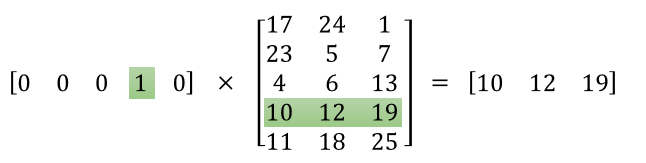